### Load packages

In [1]:
%matplotlib inline
import os,sys
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from tqdm import tqdm
import igraph as ig
import contextily as ctx
from rasterstats import zonal_stats
import time
import pylab as pl
from IPython import display
import seaborn as sns
import subprocess

from shapely.wkb import loads

data_path = os.path.join('..','data')

# path to python scripts
sys.path.append(os.path.join('..','src','trails'))

from flow_model import *
from simplify import *
from extract import railway,ferries,mainRoads,roads


pd.options.mode.chained_assignment = None  

In [2]:
#comtrade_stats = pd.read_csv(os.path.join(data_path,'comtrade.csv'))
#comtrade_stats = comtrade_stats.loc[comtrade_stats['Netweight (kg)'] > 0].reset_index(drop=True)
#comtrade_stats['avg_kg_value'] = comtrade_stats['Trade Value (US$)']/comtrade_stats['Netweight (kg)']

In [3]:
country = 'FJI'

In [4]:
osm_path = os.path.join(r'C:\Data\country_osm','{}.osm.pbf'.format(country))

transport_network = load_network(osm_path)
print('NOTE: Network created')

sg = create_graph(transport_network.edges)[0]
main_graph = pd.DataFrame(list(sg.es['geometry']),columns=['geometry'])
main_network = pd.DataFrame([list(sg.es[x]) for x in sg.es.attribute_names()]).T
main_network.columns = sg.es.attribute_names()

data_path = "C:\Data"

query is finished, lets start the loop


topology: 100%|██████████████████████████████████████████████████████████████████| 1654/1654 [00:00<00:00, 1710.43it/s]


0  Edges not connected to nodes
NOTE: Network created


NOTE: Flow analysis finished


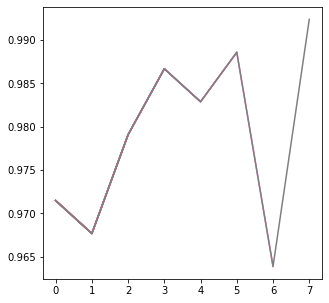

In [9]:
gdf_admin = country_grid_gdp_filled(main_graph,country,data_path,rough_grid_split=50,from_main_graph=True)

print('NOTE: GDP values extracted')

OD,OD_dict,sectors,gdf_admin = create_OD(gdf_admin,country,data_path)
print('NOTE: OD created')

gdf_out = run_flow_analysis(country,transport_network,gdf_admin,OD_dict,notebook=True)
print('NOTE: Flow analysis finished')

In [6]:
#gdf_admin['geometry'] = gdf_admin.geometry.apply(lambda x: loads(pygeos.to_wkb(x)))
gdf_out = gdf_out.loc[~gdf_out.max_flow.isna()].reset_index(drop=True)
gdf_out_save = gdf_out.copy()
gdf_out_save['geometry'] = gdf_out_save.geometry.apply(lambda x: loads(pygeos.to_wkb(x)))               

gpd.GeoDataFrame(gdf_admin.drop('centroid',axis=1)).to_file(
    os.path.join('..','data',
    '{}.gpkg'.format(country)),layer='grid',driver='GPKG')
gpd.GeoDataFrame(gdf_out_save).to_file(os.path.join('..','data',
    '{}.gpkg'.format(country)),layer='network',driver='GPKG')

In [7]:
def country_run(country,plot=True):
    """[summary]

    Args:
        country ([type]): [description]
        plot (bool, optional): [description]. Defaults to True.
    """    
    osm_path = os.path.join(r'C:\Data\OSM\country_osm','{}.osm.pbf'.format(country))
    
    transport_network = load_network(osm_path)
    print('NOTE: Network created')
    
    sg = create_graph(transport_network.edges)[0]
    main_graph = pd.DataFrame(list(sg.es['geometry']),columns=['geometry'])
    gdf_admin = country_grid_gdp_filled(main_graph,from_main_graph=True)

    print('NOTE: GDP values extracted')

    OD,OD_dict,sectors,gdf_admin = create_OD(gdf_admin,country)
    print('NOTE: OD created')
    
    gdf_out = run_flow_analysis(transport_network,gdf_admin,OD_dict)
    print('NOTE: Flow analysis finished')
    
    if plot:
        plot_results(gdf_out)    
        
    return gdf_out,gdf_admin

In [ ]:
gdf_out,gdf_admin = country_run(country,plot=False)